**TM10007 Machine Learning**

## Import dependencies and data

In [166]:
import os
import zipfile
import pandas as pd
import numpy as np
import shutil
import subprocess
import shutil
import os
import stat
import matplotlib.pyplot as plt
from os import path
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2

## if data.csv is not present download it from github
if not os.path.isfile("ecg_data.csv"):
    ## clone repo from githun
    if not os.path.isdir("tm10007_ml"):
        !git clone https://github.com/jveenland/tm10007_ml.git
    ## extract zip file
    if not os.path.isfile("tm10007_ml/ecg/ecg_data.csv"):
        with zipfile.ZipFile('tm10007_ml/ecg/ecg_data.zip', 'r') as zip_ref:
            zip_ref.extractall('tm10007_ml/ecg')
    ## move data file to root folder
    shutil.move('tm10007_ml/ecg/ecg_data.csv', 'ecg_data.csv')

    ## Delete cloned repo
    for root, dirs, files in os.walk("./tm10007_ml"):  
        for dir in dirs:
            os.chmod(path.join(root, dir), stat.S_IRWXU)
        for file in files:
            os.chmod(path.join(root, file), stat.S_IRWXU)
    shutil.rmtree('./tm10007_ml')

data = pd.read_csv('ecg_data.csv', index_col=0)

## Inspect imported data and clean missing data

### Plot number of missing data per features and per patient

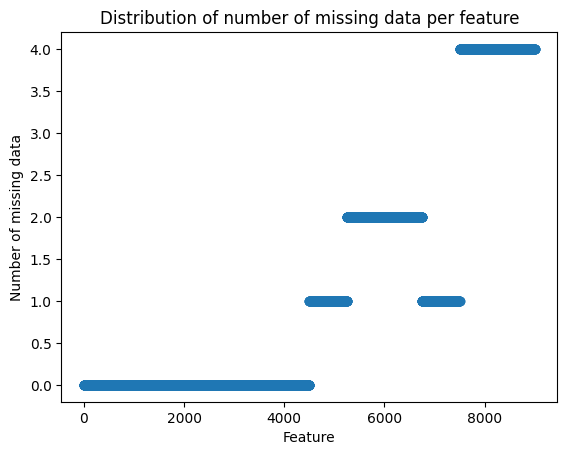

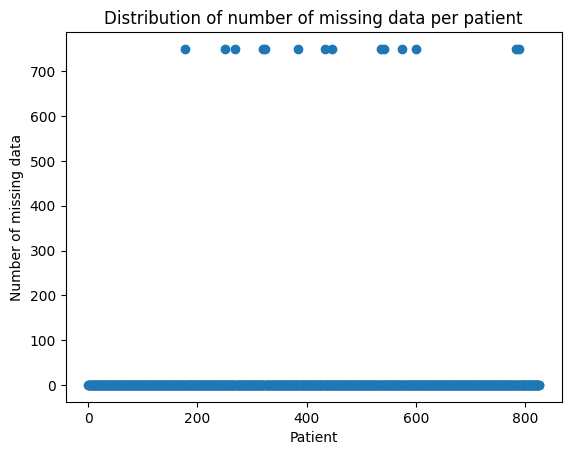

In [167]:
# exclude label column
values_features = data.drop(['label'], axis=1)

# plot the distribution of missing data per feature
num_zeros_features = (values_features == 0).sum(axis=0)
plt.scatter(range(len(num_zeros_features)),num_zeros_features)
plt.title("Distribution of number of missing data per feature")
plt.ylabel('Number of missing data')
plt.xlabel('Feature')
plt.show()

# plot the distribution of missing data per patient
num_zeros_patients=(values_features == 0).sum(axis=1)
plt.scatter(range(len(num_zeros_patients)),num_zeros_patients)
plt.title("Distribution of number of missing data per patient")
plt.ylabel('Number of missing data')
plt.xlabel('Patient')
plt.show()

### Delete rows with missing data

In [168]:
values_data = data.drop(['label'], axis=1)
mask = (values_data != 0).all(axis=1)
clean_data=data[mask]
dirty_data=data[~mask]

### Plot number of missing data per features and per patient after data cleanup

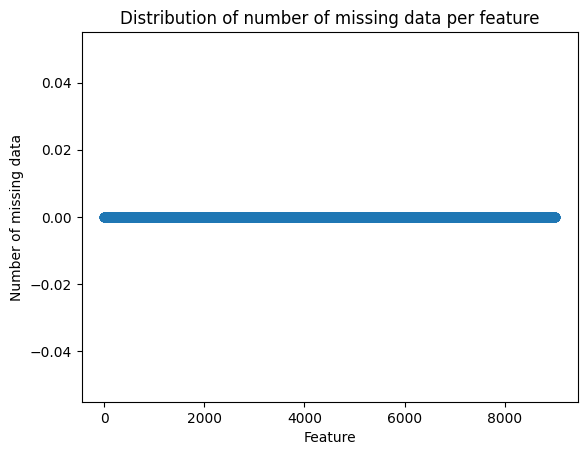

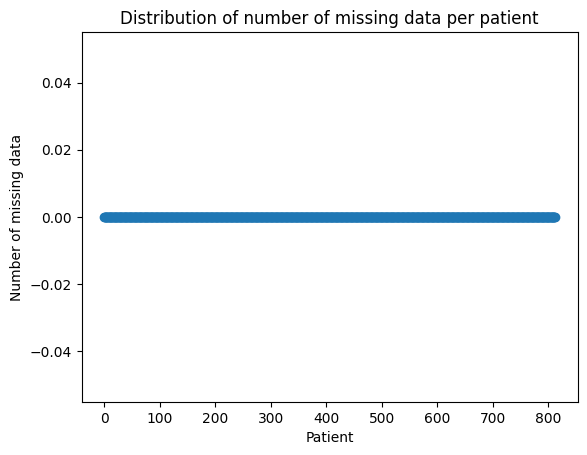

In [169]:
# exclude label column
values_clean_data = clean_data.drop(['label'], axis=1)
# plot the distribution of missing data per feature
num_zeros_features = (values_clean_data == 0).sum(axis=0)
plt.scatter(range(len(num_zeros_features)),num_zeros_features)
plt.title("Distribution of number of missing data per feature")
plt.ylabel('Number of missing data')
plt.xlabel('Feature')
plt.show()

# plot the distribution of missing data per patient
num_zeros_patients=(values_clean_data == 0).sum(axis=1)
plt.scatter(range(len(num_zeros_patients)),num_zeros_patients)
plt.title("Distribution of number of missing data per patient")
plt.ylabel('Number of missing data')
plt.xlabel('Patient')
plt.show()

## Split data into test and train data

In [170]:
x_train, x_test = model_selection.train_test_split(clean_data, test_size=0.2)

ECG_ABNORMAL = data[data['label'] == 1]
ECG_NORMAL = data[data['label'] == 0]

x_train_abnormal, x_test_abnormal = model_selection.train_test_split(ECG_ABNORMAL, test_size=0.2)
x_train_normal, x_test_normal = model_selection.train_test_split(ECG_NORMAL,test_size = 0.2)

train_set = pd.concat([x_train_normal,x_train_abnormal])
test_set = pd.concat([x_test_normal,x_test_abnormal])


## Scale features of train and test set

In [171]:
from sklearn.preprocessing import RobustScaler

# deal with outliers in the data
transformer = RobustScaler().fit(train_set)
train_set_robust = pd.DataFrame(transformer.transform(train_set))
test_set_robust = pd.DataFrame(transformer.transform(test_set))

# scaling the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
# fit the scaler on the train set
scaler.fit(train_set_robust)
# transform both train and test data set with the scaler
# rename the column names to the ones from 'data' again
train_set_scaled = pd.DataFrame(scaler.transform(train_set))
train_set_scaled.columns=data.columns.values
test_set_scaled = pd.DataFrame(scaler.transform(test_set))
test_set_scaled.columns=data.columns.values

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [172]:
# scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
# fit the scaler on the train set
scaler.fit(train_set)
# transform both train and test data set with the scaler
# rename the column names to the ones from 'data' again
train_set_scaled = pd.DataFrame(scaler.transform(train_set))
train_set_scaled.columns=data.columns.values
test_set_scaled = pd.DataFrame(scaler.transform(test_set))
test_set_scaled.columns=data.columns.values

In [173]:
x_train_val, x_val = model_selection.train_test_split(train_set_scaled, test_size=0.2)

ecg_train_abnormal = train_set_scaled[train_set_scaled['label'] == 1]
ecg_train_normal = train_set_scaled[train_set_scaled['label'] == 0]

v_train_abnormal, v_val_abnormal = model_selection.train_test_split(ecg_train_abnormal, test_size=0.2)
v_train_normal, v_val_normal = model_selection.train_test_split(ecg_train_normal,test_size = 0.2)

train_set_scaled = pd.concat([v_train_normal,v_train_abnormal])
validation_set = pd.concat([v_val_normal,v_val_abnormal])

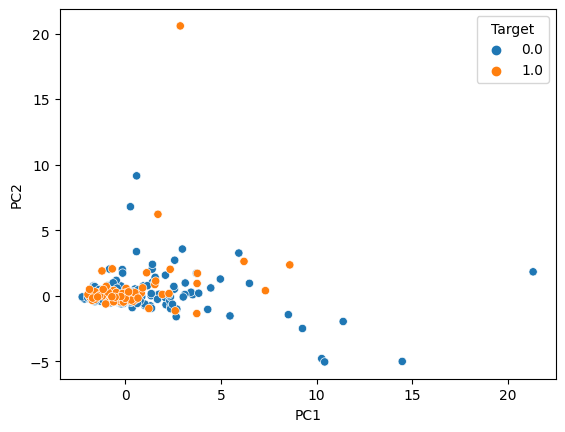

[0.20382044 0.08119979]


In [187]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

x = train_set_scaled.iloc[:, :-1].values
y = train_set_scaled.iloc[:, -1].values

pca = PCA(n_components=2)
X_pca = pca.fit_transform(x)
X_val = validation_set.iloc[:,:-1].values
y_val = validation_set.iloc[:,-1].values
X_val_pca = pca.transform(X_val)

df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_pca['Target'] = y

sns.scatterplot(x='PC1', y='PC2', hue='Target', data=df_pca)
plt.show()

print(pca.explained_variance_ratio_)

Misclassified by KNN algorithm =           0
0  0.166983


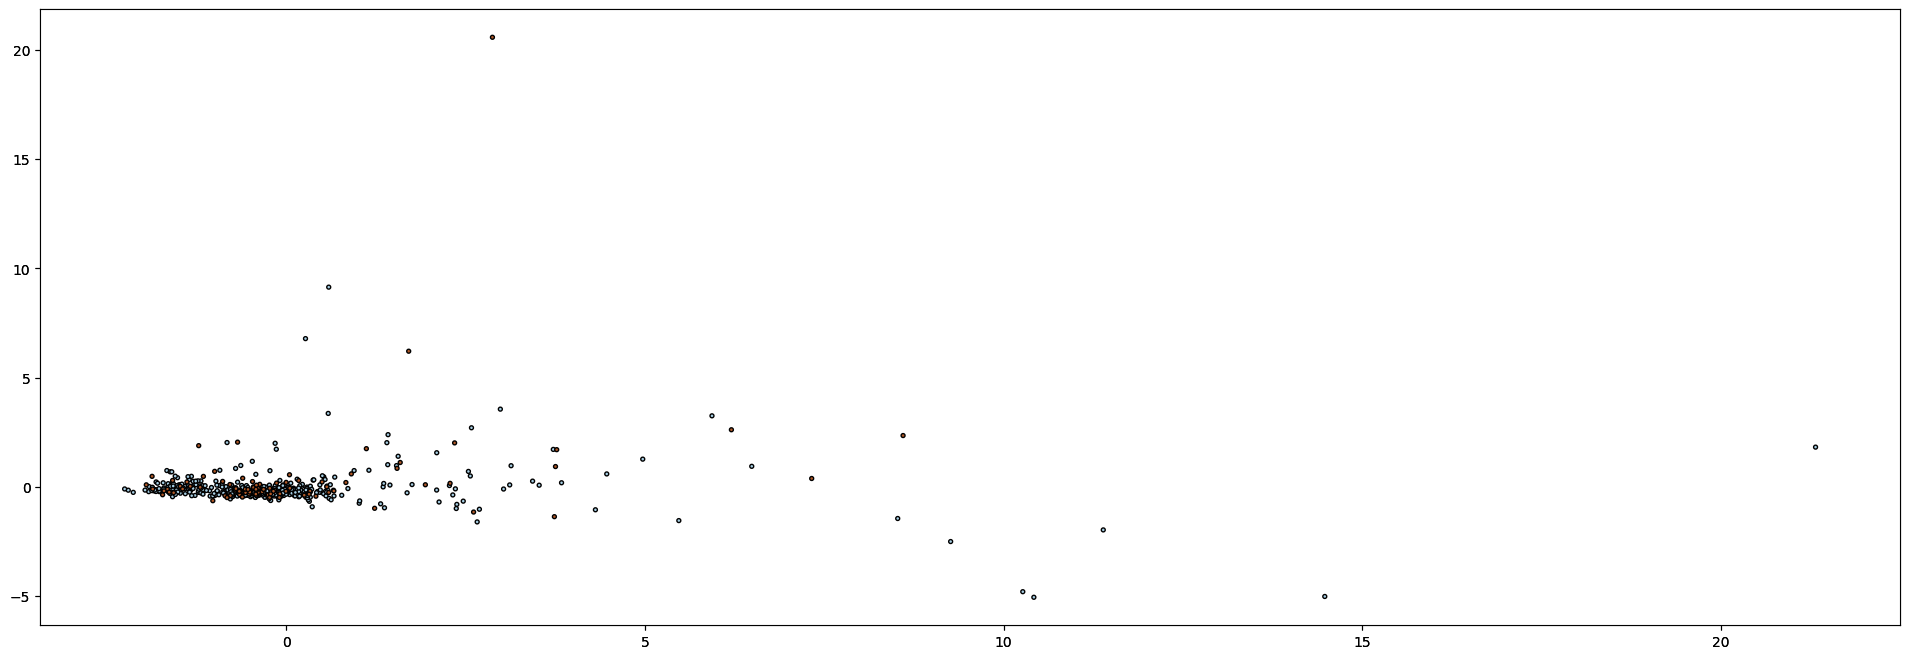

In [192]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier

clsfs = KNeighborsClassifier()
fig = plt.figure(figsize=(24,8))

ax = fig.add_subplot()
ax.scatter(X_pca[:, 0], X_pca[:, 1], marker='o', c=y,
        s=25, edgecolor='k', cmap=plt.cm.Paired)

clsfs.fit(X_pca,y)

ax = fig.add_subplot()
ax.scatter(X_pca[:,0],X_pca[:,1],marker='o',c=y,s=8,edgecolor='k',cmap=plt.cm.Paired)

y_pred = pd.DataFrame(clsfs.predict(X_pca))
correct = pd.DataFrame(y)

percentage = pd.DataFrame((correct != y_pred).sum() / len(y_pred))
print(f'Misclassified by KNN algorithm = {percentage}')


Correctly classified by QDA classifier = 80.45%


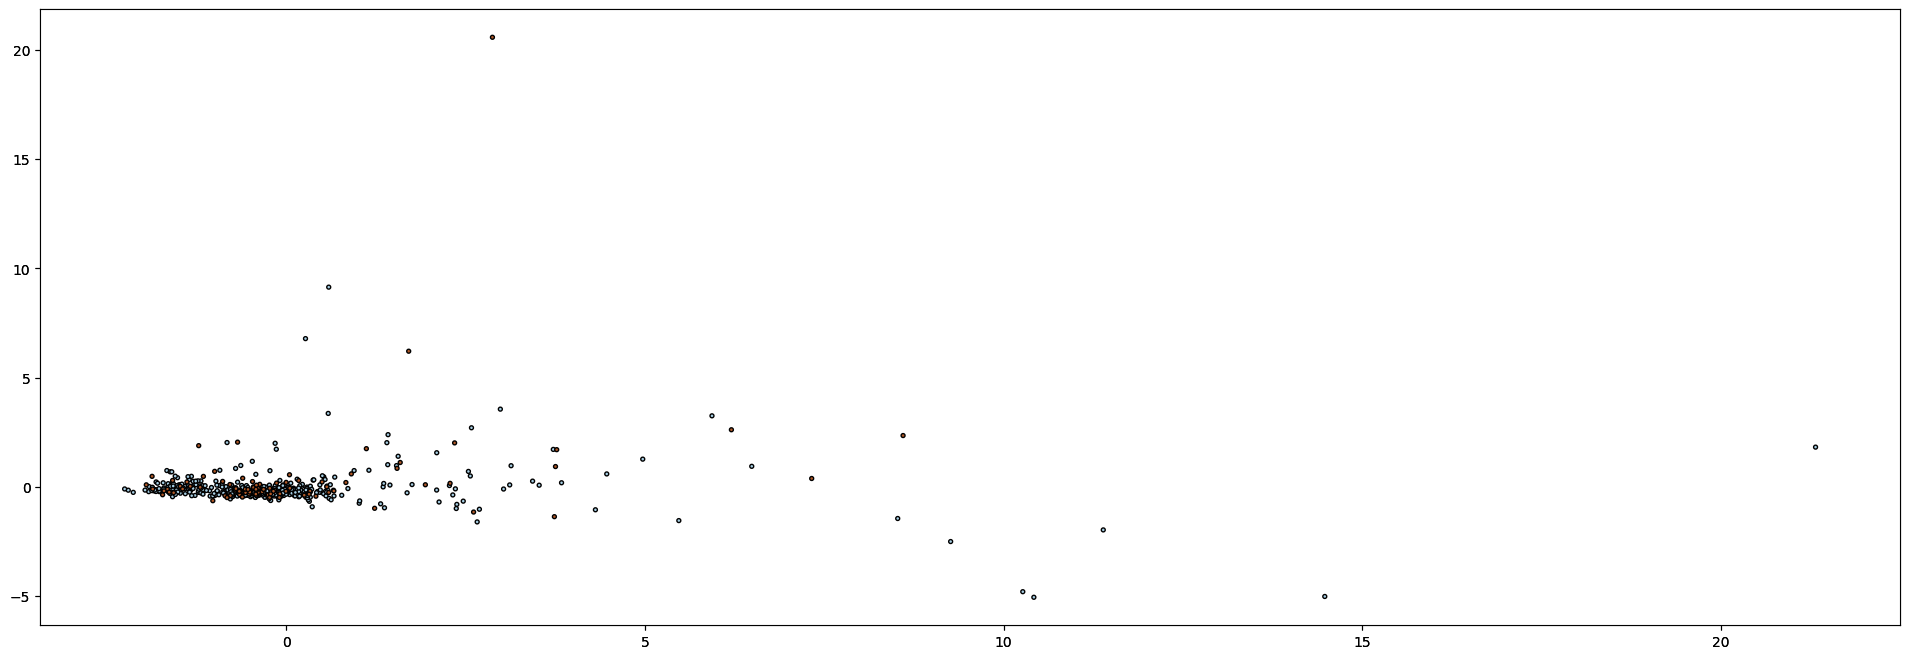

In [188]:
# Quadratic Discriminant Analysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis()
fig = plt.figure(figsize=(24,8))
ax = fig.add_subplot()
ax.scatter(X_pca[:, 0], X_pca[:, 1], marker='o', c=y,
        s=25, edgecolor='k', cmap=plt.cm.Paired)
qda.fit(X_pca,y)
ax = fig.add_subplot()
ax.scatter(X_pca[:,0],X_pca[:,1],marker='o',c=y,s=8,edgecolor='k',cmap=plt.cm.Paired)
y_pred = pd.DataFrame(qda.predict(X_val_pca))
correct = pd.DataFrame(y_val)
percentage = pd.DataFrame((correct != y_pred).sum() / len(y_pred))
percentage_value = percentage.iloc[:,:].values
float_percentage = 100-(float(percentage_value)*100)
rounded_percentage = "{:.2f}".format(float_percentage)
print(f'Correctly classified by QDA classifier = {rounded_percentage}%')

Correctly classified by Gaussian classifier = 80.45%


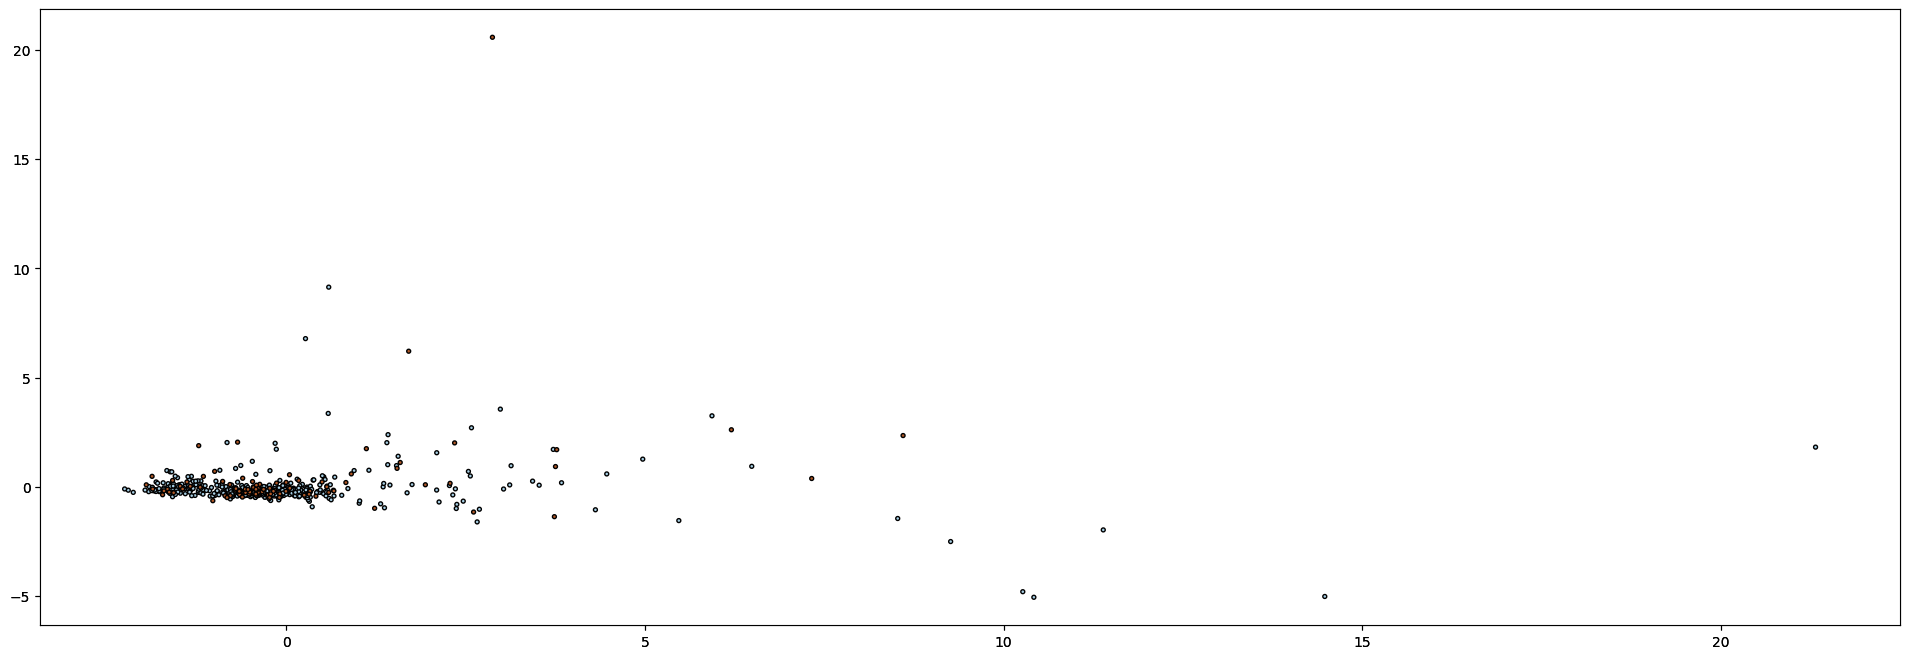

In [191]:
# Gaussian
from sklearn.naive_bayes import GaussianNB
gauss = GaussianNB()
fig = plt.figure(figsize=(24,8))
ax = fig.add_subplot()
ax.scatter(X_pca[:, 0], X_pca[:, 1], marker='o', c=y,
        s=25, edgecolor='k', cmap=plt.cm.Paired)
gauss.fit(X_pca,y)
ax = fig.add_subplot()
ax.scatter(X_pca[:,0],X_pca[:,1],marker='o',c=y,s=8,edgecolor='k',cmap=plt.cm.Paired)
y_pred = pd.DataFrame(gauss.predict(X_val_pca))
correct = pd.DataFrame(y_val)
percentage = pd.DataFrame((correct != y_pred).sum() / len(y_pred))
percentage_value = percentage.iloc[:,:].values
float_percentage = 100-(float(percentage_value)*100)
rounded_percentage = "{:.2f}".format(float_percentage)
print(f'Correctly classified by Gaussian classifier = {rounded_percentage}%')

Correctly classified by SVM RBF classifier = 81.95%


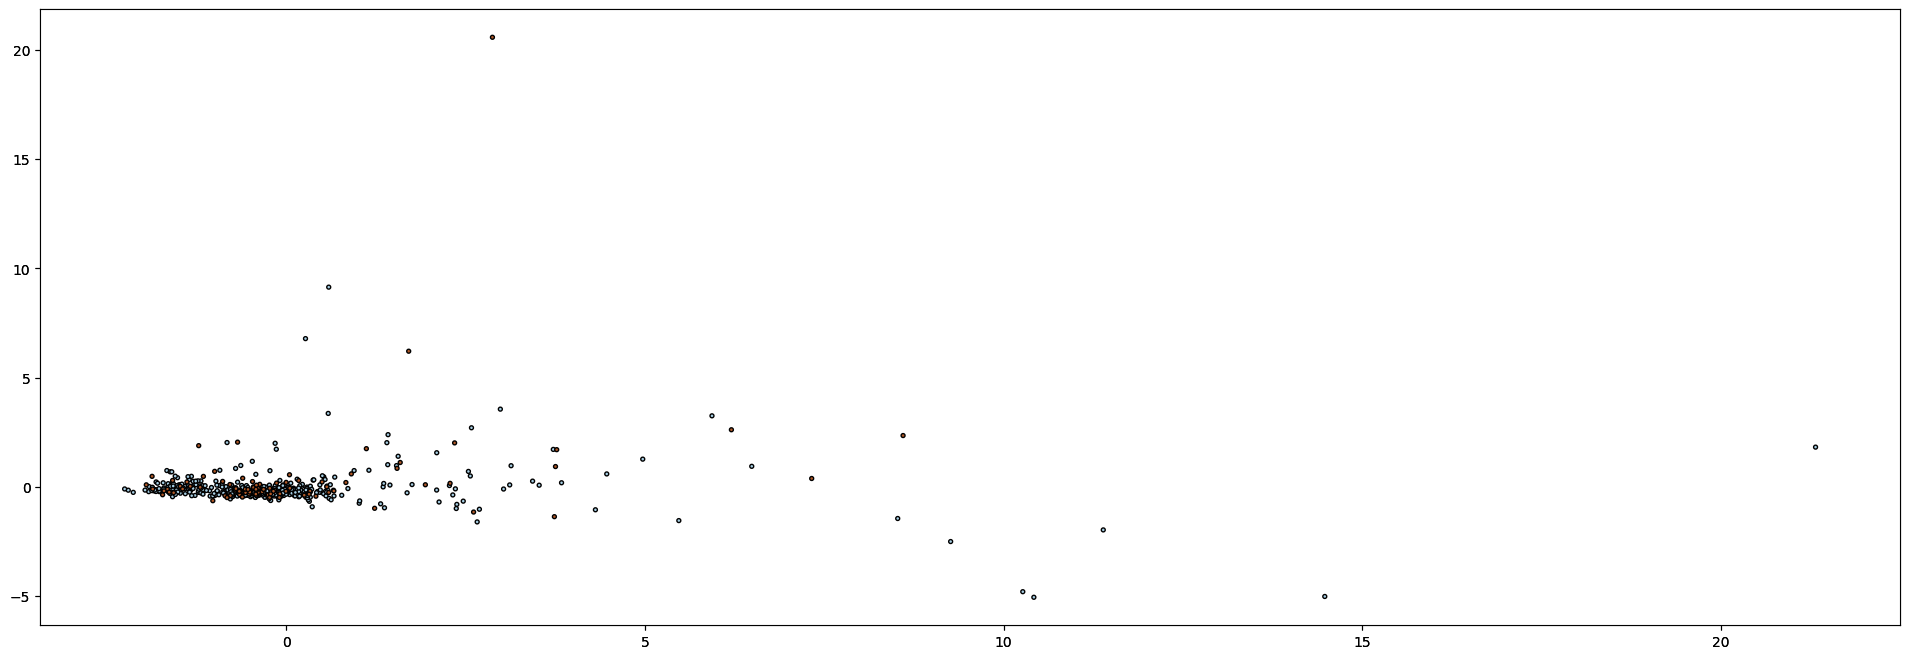

In [190]:
# SVM RBF
from sklearn.svm import SVC
from sklearn.decomposition import PCA, KernelPCA
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics.pairwise import rbf_kernel, sigmoid_kernel

svmrbf = SVC(kernel='rbf', gamma='scale')
fig = plt.figure(figsize=(24,8))
ax = fig.add_subplot()
ax.scatter(X_pca[:, 0], X_pca[:, 1], marker='o', c=y,
        s=25, edgecolor='k', cmap=plt.cm.Paired)
svmrbf.fit(X_pca,y)
ax = fig.add_subplot()
ax.scatter(X_pca[:,0],X_pca[:,1],marker='o',c=y,s=8,edgecolor='k',cmap=plt.cm.Paired)
y_pred = pd.DataFrame(svmrbf.predict(X_val_pca))
correct = pd.DataFrame(y_val)
percentage = pd.DataFrame((correct != y_pred).sum() / len(y_pred))
percentage_value = percentage.iloc[:,:].values
float_percentage = 100-(float(percentage_value)*100)
rounded_percentage = "{:.2f}".format(float_percentage)
print(f'Correctly classified by SVM RBF classifier = {rounded_percentage}%')

Correctly classified by SVM polynomial classifier = 81.20%


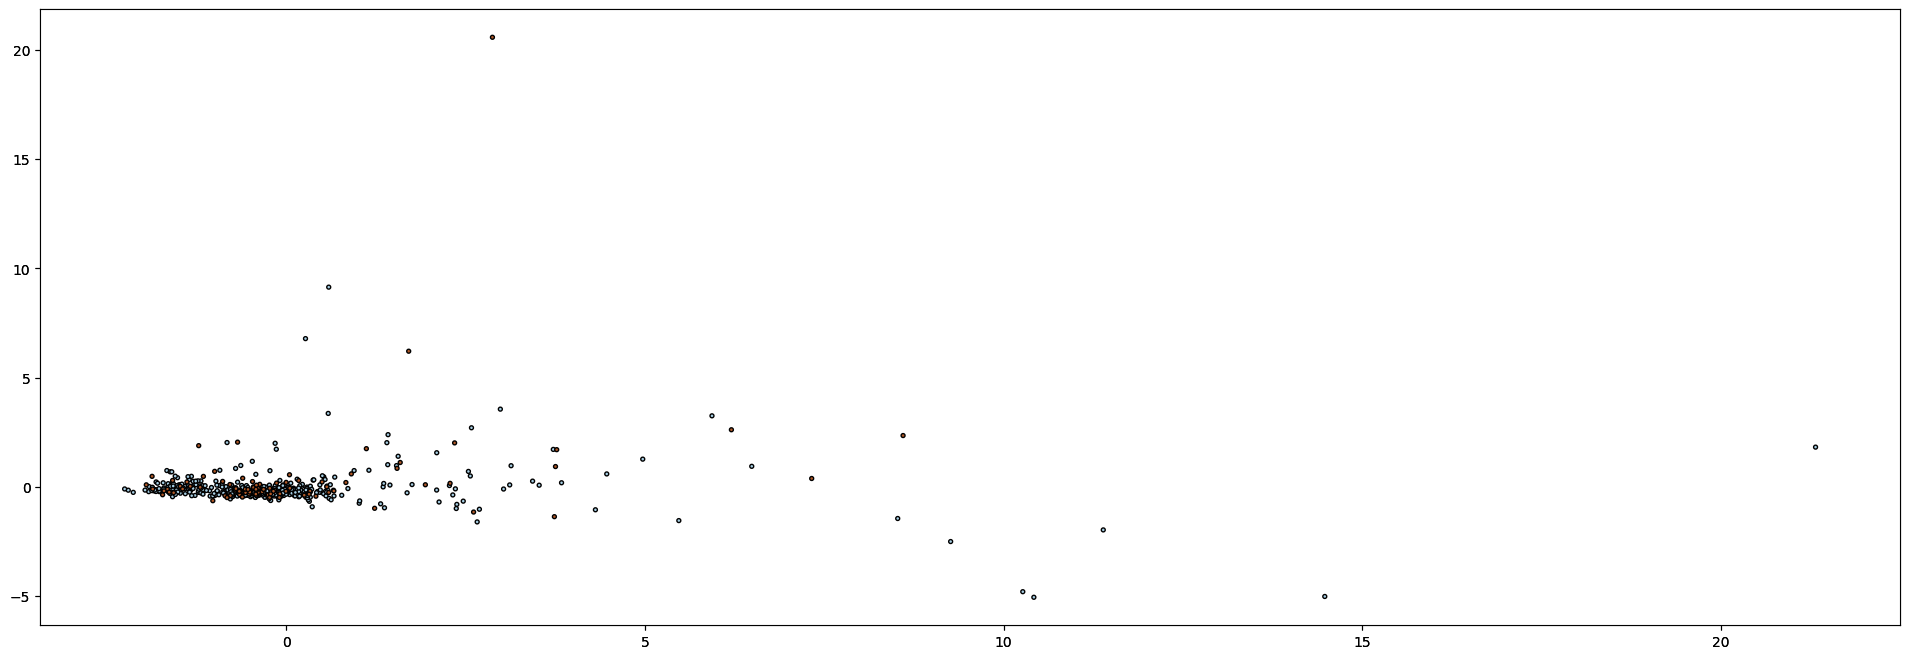

In [189]:
# SVM polynomial
svmpoly = SVC(kernel='poly', degree=3, gamma='scale')
fig = plt.figure(figsize=(24,8))
ax = fig.add_subplot()
ax.scatter(X_pca[:, 0], X_pca[:, 1], marker='o', c=y,
        s=25, edgecolor='k', cmap=plt.cm.Paired)
svmpoly.fit(X_pca,y)
ax = fig.add_subplot()
ax.scatter(X_pca[:,0],X_pca[:,1],marker='o',c=y,s=8,edgecolor='k',cmap=plt.cm.Paired)
y_pred = pd.DataFrame(svmpoly.predict(X_val_pca))
correct = pd.DataFrame(y_val)
percentage = pd.DataFrame((correct != y_pred).sum() / len(y_pred))
percentage_value = percentage.iloc[:,:].values
float_percentage = 100-(float(percentage_value)*100)
rounded_percentage = "{:.2f}".format(float_percentage)
print(f'Correctly classified by SVM polynomial classifier = {rounded_percentage}%')